(1000, 1000)


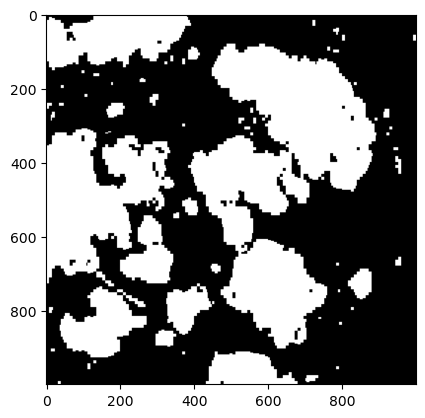

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
from scipy import ndimage as ndi

import napari

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

os.chdir("E:/data_for_seg/z_projection/split")
# Example: List the contents of the current folder
files = os.listdir()
files = [file for file in files if "Simple" in file]
image = cv2.imread(files[0], cv2.IMREAD_GRAYSCALE)
image = np.where(image == 255, 0, 255)
image = image.astype(np.uint8)
print(image.shape)
plt.imshow(image, cmap="gray")
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=image)

viewer = napari.Viewer()
image_layer = viewer.add_image(image)
labels_layer = viewer.add_labels(labels)
labels_as_image_layer = viewer.add_image(
    labels, name='labels as image'
)

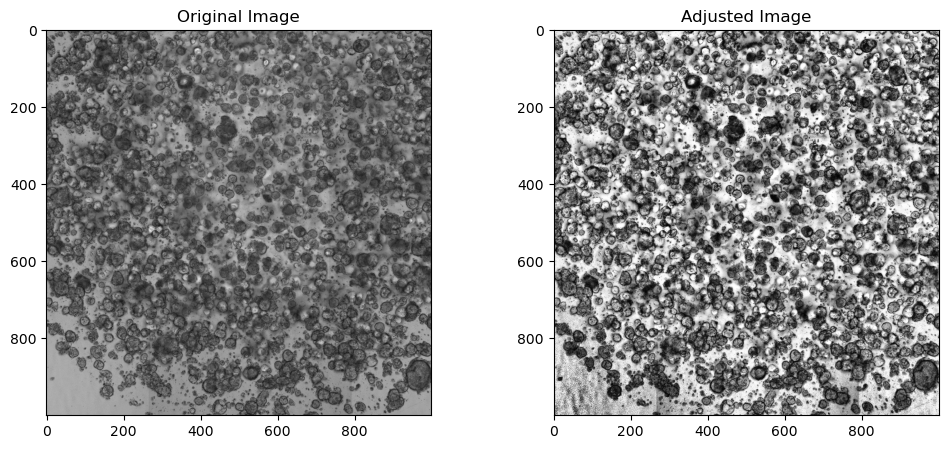

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

# Load your image
os.chdir("E:/data_for_seg/z_projection/receed0")
files = os.listdir()

# Load the first image in the directory in grayscale
image = cv2.imread(files[0], cv2.IMREAD_GRAYSCALE)

# Define the gamma value
gamma = 2

# Define the contrast limit
contrast_limit = 70

# Apply gamma correction to the grayscale image
gamma_corrected = cv2.pow(image / 255.0, gamma) * 255.0
gamma_corrected = cv2.convertScaleAbs(gamma_corrected)

# Apply contrast adjustment with CLAHE to the grayscale image
clahe = cv2.createCLAHE(clipLimit=contrast_limit)
adjusted_image = clahe.apply(gamma_corrected)

# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Original grayscale image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')

# Adjusted image
plt.subplot(1, 2, 2)
plt.title("Adjusted Image")
plt.imshow(adjusted_image, cmap='gray')

plt.show()

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
from scipy import ndimage as ndi

import napari

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

spacing = np.array([0.26, 0.26])

viewer = napari.view_image(
    adjusted_image,
    scale=spacing,
    ndisplay=2,
)

In [14]:
from skimage import filters

edges = filters.scharr(image)
viewer.add_image(
    edges,
    scale=spacing,
    blending='additive',
    colormap='magenta',
)

<Image layer 'edges' at 0x2712b268280>

In [15]:
denoised = ndi.median_filter(image, size=3)
li_thresholded = denoised > filters.threshold_li(denoised)
viewer.add_image(
    li_thresholded,
    scale=spacing,
    opacity=0.3,
)

<Image layer 'li_thresholded' at 0x2713a2d0970>

In [16]:
from scipy import ndimage

li_thresholded = np.array([[not cell for cell in row] for row in li_thresholded])

li_thresholded = ndimage.binary_fill_holes(li_thresholded).astype(int)

viewer.add_image(
    li_thresholded,
    name='fill_holes',
    scale=spacing,
    opacity=0.3,
);


In [17]:
from skimage import morphology

width = 2

remove_holes = morphology.remove_small_holes(
    li_thresholded, width ** 3
)

width = 2

remove_objects = morphology.remove_small_objects(
    remove_holes, width ** 3
)

viewer.add_image(
    remove_objects,
    name='cleaned',
    scale=spacing,
    opacity=0.3,
);

viewer.layers['li_thresholded'].visible = False

C:\Users\laure\AppData\Local\Temp\ipykernel_55648\2341530278.py:5: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  remove_holes = morphology.remove_small_holes(


In [18]:
from skimage import measure

labels = measure.label(remove_objects)

viewer.add_labels(
    labels,
    scale=spacing,
    opacity=0.5,
)

viewer.layers['cleaned'].visible = False

In [143]:
"""
transformed = ndi.distance_transform_edt(remove_objects, sampling=spacing)

maxima = morphology.local_maxima(transformed)
viewer.add_points(
    np.transpose(np.nonzero(maxima)),
    name='bad points',
    scale=spacing,
    size=3,
    n_dimensional=True,  # points have 3D "extent"
)
"""

<Points layer 'bad points' at 0x2331d3a52a0>

In [153]:
"""
from skimage import segmentation

marker_locations = maxima

markers = np.zeros(image.shape, dtype=np.uint32)
marker_indices = tuple(np.round(marker_locations).astype(int).T)
markers[marker_indices] = np.arange(len(marker_locations)) + 1
markers_big = morphology.dilation(markers, morphology.disk(radius=5))

segmented = segmentation.watershed(
    edges,
    markers_big,
    mask=remove_objects,
)

viewer.add_labels(
    segmented,
    scale=spacing,
)

viewer.layers['labels'].visible = False
"""

"\nfrom skimage import segmentation\n\nmarker_locations = maxima\n\nmarkers = np.zeros(image.shape, dtype=np.uint32)\nmarker_indices = tuple(np.round(marker_locations).astype(int).T)\nmarkers[marker_indices] = np.arange(len(marker_locations)) + 1\nmarkers_big = morphology.dilation(markers, morphology.disk(radius=5))\n\nsegmented = segmentation.watershed(\n    edges,\n    markers_big,\n    mask=remove_objects,\n)\n\nviewer.add_labels(\n    segmented,\n    scale=spacing,\n)\n\nviewer.layers['labels'].visible = False\n"

In [154]:
regionprops = measure.regionprops(labels, intensity_image=image)

supported = [] 
unsupported = []

for prop in regionprops[0]:
    try:
        regionprops[0][prop]
        supported.append(prop)
    except NotImplementedError:
        unsupported.append(prop)

print("Supported properties:")
print("  " + "\n  ".join(supported))
print()
print("Unsupported properties:")
print("  " + "\n  ".join(unsupported))

Supported properties:
  area
  area_bbox
  area_convex
  area_filled
  axis_major_length
  axis_minor_length
  bbox
  centroid
  centroid_local
  centroid_weighted
  centroid_weighted_local
  coords
  eccentricity
  equivalent_diameter_area
  euler_number
  extent
  feret_diameter_max
  image
  image_convex
  image_filled
  image_intensity
  inertia_tensor
  inertia_tensor_eigvals
  intensity_max
  intensity_mean
  intensity_min
  label
  moments
  moments_central
  moments_hu
  moments_normalized
  moments_weighted
  moments_weighted_central
  moments_weighted_hu
  moments_weighted_normalized
  orientation
  perimeter
  perimeter_crofton
  slice
  solidity

Unsupported properties:
  


In [161]:
import pandas as pd

info_table = pd.DataFrame(
    measure.regionprops_table(
        labels,
        intensity_image=image,
        properties=['label', 'slice', 'area', 'mean_intensity', 'solidity'],
    )
).set_index('label')

In [164]:
info_table.head()

,slice,area,mean_intensity,solidity
label,,,,
1,"(slice(0, 32, None), slice(97, 112, None))",160.0,48.987500,0.601504
2,"(slice(0, 2, None), slice(124, 136, None))",17.0,57.117647,0.850000
3,"(slice(0, 6, None), slice(148, 157, None))",38.0,48.815789,0.826087
4,"(slice(0, 9, None), slice(170, 202, None))",126.0,48.928571,0.529412
5,"(slice(0, 6, None), slice(227, 234, None))",30.0,54.266667,0.909091
